<a href="https://colab.research.google.com/github/paragrafff22/driving-lessons/blob/master/cars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!nvidia-smi

Sun Feb  9 21:15:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    26W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import numpy as np
import matplotlib.pyplot as plt
!pip install imgaug
from imgaug import augmenters as iaa
from imgaug import parameters as iap
import random
from sklearn.model_selection import train_test_split

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D,Lambda
!pip install livelossplot
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


In [0]:
X = np.load('X.npy')
y = np.load('y.npy')

In [0]:
print(X.shape,y.shape)

(4239, 60, 80, 3) (4239,)


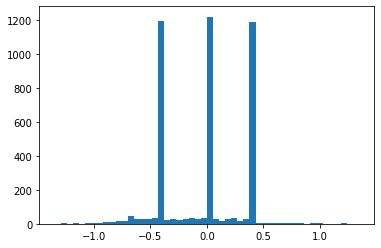

In [0]:
plt.hist(y,50);

0.0


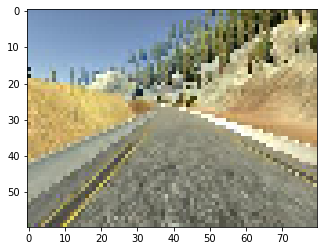

0.025


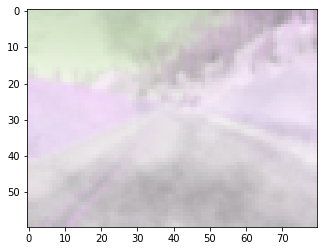

In [0]:
def augment(img,steering_angle):
  # Filp
  if random.random() > 0.5:
    img = img[:,::-1,:]
    steering_angle = -steering_angle
  #Blur
  blurer = iaa.GaussianBlur(iap.Uniform(0.1, 1.0))
  img = blurer.augment_image(img)
  #shuffle
  sh = iaa.ChannelShuffle(p=0.5)
  img = sh.augment_image(img)
  #fog
  fog = iaa.Fog()
  img = fog.augment_image(img)
  #translate
  tx = random.randint(-20,20)
  translater = iaa.Affine(translate_px={'x':tx}, mode='edge')
  img = translater.augment_image(img)
  steering_angle += tx*0.025

  return img,steering_angle

plt.imshow(X[100])
print(y[100])
plt.show()

img, angle = augment(X[100],y[100])
plt.imshow(img)
print(angle)
plt.show()




In [0]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=42)

In [0]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)

(3391, 60, 80, 3) (3391,)
(848, 60, 80, 3) (848,)


In [0]:
Xgen = []
ygen = []
for i in range(X_train.shape[0]):
  img, angle = augment(X[i],y[i])
  Xgen.append(img)
  ygen.append(angle)
Xgen = np.array(Xgen)
ygen = np.array(ygen)
print(Xgen.shape,ygen.shape)

(3391, 60, 80, 3) (3391,)


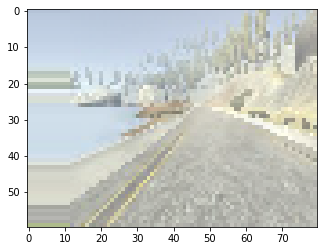

In [0]:
plt.imshow(Xgen[0])

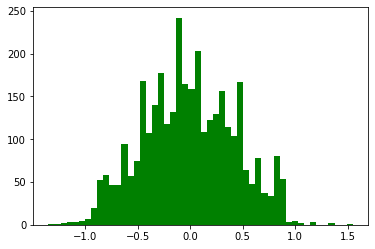

In [0]:
plt.hist(ygen,50,facecolor='green');

In [0]:
def mymodel(input_shape):
  model = Sequential([
          Lambda(lambda x: (x-128.0)/255,input_shape=input_shape,name='normalize'),
          Conv2D(64,(3,3),activation='relu'),
          #MaxPooling2D(pool_size=(2,2)),
          Conv2D(32,(3,3),activation='relu'),
          MaxPooling2D(pool_size=(2,2)),
          Conv2D(16,(3,3),activation='relu'),
          MaxPooling2D(pool_size=(2,2)),
          Conv2D(8,(3,3),activation='relu'),
          MaxPooling2D(pool_size=(2,2)),
          Dropout(rate=0.5),
          Flatten(),
          Dense(512,activation='relu'),
          Dropout(rate=0.3),
          Dense(512,activation='relu'),
          Dropout(rate=0.3),
          Dense(16,activation='relu'),
          Dense(1)

  ])
  return model
model = mymodel(X[0].shape)
model.summary()
model.compile('adam','mse')






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalize (Lambda)           (None, 60, 80, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 78, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 76, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 38, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 36, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 18, 16)        0         


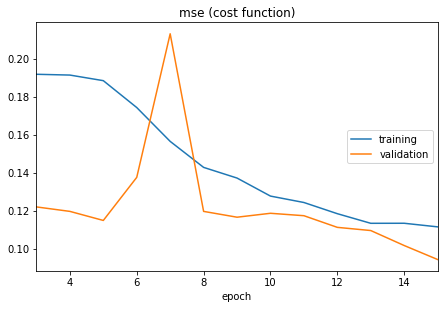

mse (cost function):
training   (min:    0.111, max:    0.195, cur:    0.111)
validation (min:    0.094, max:    0.213, cur:    0.094)


In [0]:
batch_size = 512
epochs = 15

model.fit(Xgen,ygen,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_val,y_val),
          callbacks=[PlotLossesKeras()])

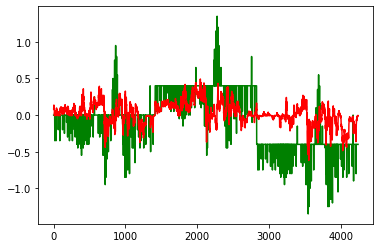

In [0]:
ypred = model.predict(X)
plt.plot(y,'g',ypred,'r')
plt.show()

In [0]:
model.save('mymodel.h5')